In [41]:
import pandas as pd
from utils import data_wrangling as dw
from utils import ts_wrangling as tw
from utils import plots 
from models import lf_models as am
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import seaborn as sns
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    CrostonOptimized,
    TSB,
    MSTL,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
)

In [2]:
INIT = "2012-01-01"
END = "2023-02-28"
PERIOD = 24*365
HORIZON = 24*2

# Dados

In [5]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-03-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [6]:
df_load.describe()

,load_mwmed
count,8760.000000
mean,11641.760189
std,2295.359889
min,5755.558000
25%,9782.649250
50%,11768.670030
75%,13344.280750
max,18345.403000


In [7]:
train, test = tw.train_test_split(df_load, test=HORIZON)

# Modelos

In [23]:
df_fc = am.auto_arima_model(df=train, h_=HORIZON)

In [29]:
df_fc.head()

,ds,AutoARIMA
unique_id,,
hourly_load,2023-02-27 00:00:00,10583.355469
hourly_load,2023-02-27 01:00:00,10007.152344
hourly_load,2023-02-27 02:00:00,9638.824219
hourly_load,2023-02-27 03:00:00,9451.693359
hourly_load,2023-02-27 04:00:00,9384.501953


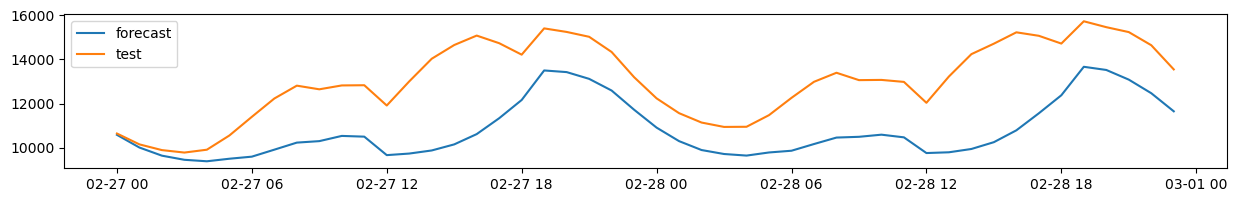

In [36]:
plt.figure(figsize=(15,2))
plt.plot(df_fc.ds, df_fc.AutoARIMA, label="forecast")
plt.plot(test.index, test.load_mwmed, label="test")
plt.legend()
plt.show()

In [ ]:
forecasts_df = sf.forecast(h=48, level=[90])

# Comparação de modelos

In [8]:
df_sf = dw.prepare_statsforecast_df(train, "hourly_load")

In [9]:
models = [
    AutoARIMA(season_length=24),
    #HoltWinters(), #erro: nonseasonal
    Croston(),
    CrostonOptimized(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    #TSB(),
    MSTL(season_length=[24, 24*7]),
    HistoricAverage(),
    AutoETS(),
    AutoCES(),
    AutoTheta()
]

In [10]:
sf = StatsForecast(
    df=df_sf, 
    models=models,
    freq='H', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=24)
)

In [11]:
sf.fit(df_sf)

StatsForecast(models=[AutoARIMA,CrostonClassic,CrostonOptimized,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,MSTL,HistoricAverage,AutoETS,CES,AutoTheta])

In [12]:
forecasts_df = sf.forecast(h=48, level=[99, 95, 90])

forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99,CrostonClassic,CrostonOptimized,...,AutoETS-hi-95,AutoETS-hi-99,CES,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,AutoTheta-lo-95,AutoTheta-hi-95,AutoTheta-lo-90,AutoTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
hourly_load,2023-02-27 00:00:00,10583.355469,9818.888672,10001.667969,10095.188477,11071.523438,11165.043945,11347.823242,10750.967773,11754.276367,...,12614.221680,13011.828125,11460.994141,11335.722656,9873.739258,12827.451172,10263.340820,12612.908203,10354.405273,12573.477539
hourly_load,2023-02-27 01:00:00,10007.152344,8580.058594,8921.267578,9095.849609,10918.455078,11093.037109,11434.246094,10750.967773,11754.276367,...,13162.786133,13726.069336,11423.147461,11335.722656,9174.249023,13708.076172,9511.812500,13044.305664,9852.372070,12884.868164
hourly_load,2023-02-27 02:00:00,9638.824219,7719.761719,8178.598145,8413.363281,10864.285156,11099.050781,11557.886719,10750.967773,11754.276367,...,13590.881836,14281.987305,11376.624023,11335.722656,8699.185547,14012.373047,8942.464844,13455.631836,9185.199219,13169.217773
hourly_load,2023-02-27 03:00:00,9451.693359,7219.575195,7753.261230,8026.324219,10877.062500,11150.125977,11683.811523,10750.967773,11754.276367,...,13956.975586,14756.420898,11337.295898,11335.722656,8025.460938,14847.213867,8853.460938,13802.066406,9159.901367,13208.197266
hourly_load,2023-02-27 04:00:00,9384.501953,6976.620117,7552.330078,7846.894531,10922.108398,11216.672852,11792.382812,10750.967773,11754.276367,...,14283.671875,15179.077148,11292.523438,11335.722656,7620.568848,14514.342773,8364.412109,14128.871094,9096.256836,13600.580078


In [13]:
# plt.figure(figsize=(15,5))
# plt.plot(forecasts_df.ds, forecasts_df.AutoARIMA, color="black", label="Observado")
# plt.fill_between(forecasts_df.ds, forecasts_df["AutoARIMA-hi-99"],forecasts_df["AutoARIMA-lo-99"], alpha=.2, color="darkblue", label="IC - 99%")
# plt.fill_between(forecasts_df.ds, forecasts_df["AutoARIMA-hi-95"],forecasts_df["AutoARIMA-lo-95"], alpha=.25, color="darkblue", label="IC - 95%")
# plt.fill_between(forecasts_df.ds, forecasts_df["AutoARIMA-hi-90"],forecasts_df["AutoARIMA-lo-90"], alpha=.25, color="darkblue", label="IC - 90%")
# #plt.legend()
# plt.legend(bbox_to_anchor = (1.15,1)) 
# plt.show()

In [16]:
forecasts_df_arima = forecasts_df[[x for x in forecasts_df.columns if "ARIMA" in x or "ds" in x]]

In [17]:
forecasts_df_arima.head()

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99
unique_id,,,,,,,,
hourly_load,2023-02-27 00:00:00,10583.355469,9818.888672,10001.667969,10095.188477,11071.523438,11165.043945,11347.823242
hourly_load,2023-02-27 01:00:00,10007.152344,8580.058594,8921.267578,9095.849609,10918.455078,11093.037109,11434.246094
hourly_load,2023-02-27 02:00:00,9638.824219,7719.761719,8178.598145,8413.363281,10864.285156,11099.050781,11557.886719
hourly_load,2023-02-27 03:00:00,9451.693359,7219.575195,7753.261230,8026.324219,10877.062500,11150.125977,11683.811523
hourly_load,2023-02-27 04:00:00,9384.501953,6976.620117,7552.330078,7846.894531,10922.108398,11216.672852,11792.382812


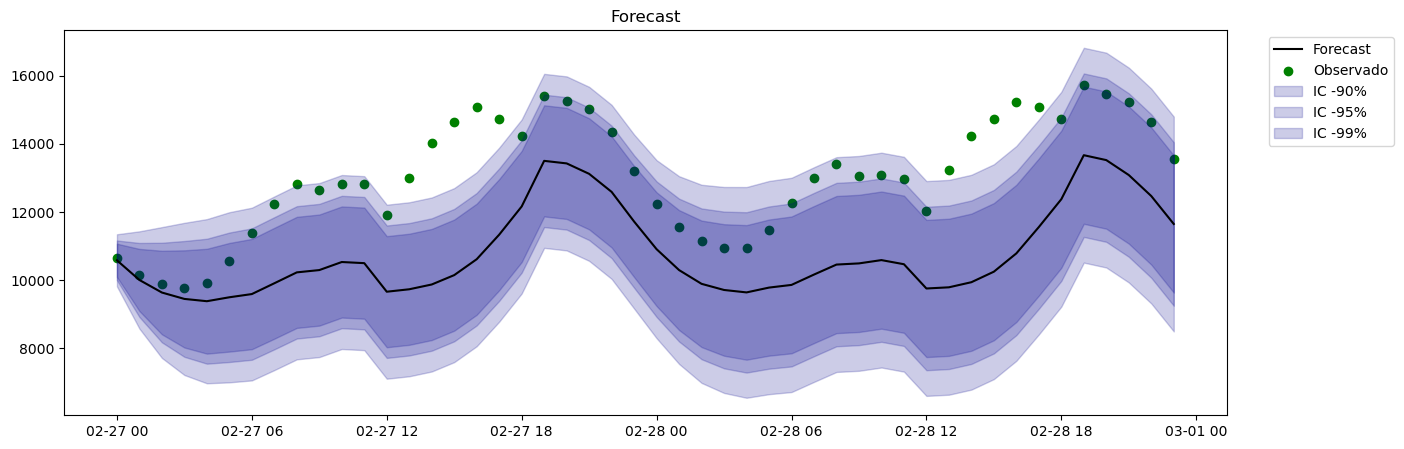

In [40]:
def plot_with_confidence(data: pd.DataFrame, 
                         x_: str, 
                         y_: str, 
                         levels: list=[90], 
                         title_=None, 
                         color: str='darkblue', 
                         alpha=.2, 
                         test: pd.Series=None, 
                         save=False):
    """Plota forecast junto com os intervalos de confiança. Importante: é necessário que os ICs estejam
    especificados no nome da coluna (ex.: ['AutoARIMA-lo-90', 'AutoARIMA-hi-90'])

    Args:
        y_ (pd.DataFrame): Dataframe com observado e ICs
        x_ (pd.Series): Data
        levels (list, optional): _description_. Defaults to [90].
        title_ (_type_, optional): _description_. Defaults to None.
        test (pd.Series, optional): inclui os valores observados da partição de teste, se houver.
            É necessário que o índice da série seja a data.
        save (bool, optional): _description_. Defaults to False.
    """
    plt.figure(figsize=(15,5))
    plt.plot(data[x_], data[y_], color="black", label="Forecast")
    if test is not None:
        plt.scatter(x=test.index, y=test, color="green", label="Observado")
    for ic in levels:
        cols = [x for x in data.columns if f"{ic}" in x]
        plt.fill_between(data[x_], data[cols[1]], data[cols[0]], alpha=alpha, label=f"IC -{ic}%", color=color)
    plt.title(title_)
    plt.legend(bbox_to_anchor = (1.15,1))
    if save:
        plt.savefig(f"../figs/{title_}.png")
    else:
        plt.show()
df_test = test.drop(["id_reg", "desc_reg"], axis=1)
plot_with_confidence(data=forecasts_df_arima, x_="ds", y_="AutoARIMA", levels=[90, 95, 99], test=df_test, title_="Forecast")

NameError: name 'ytest' is not defined

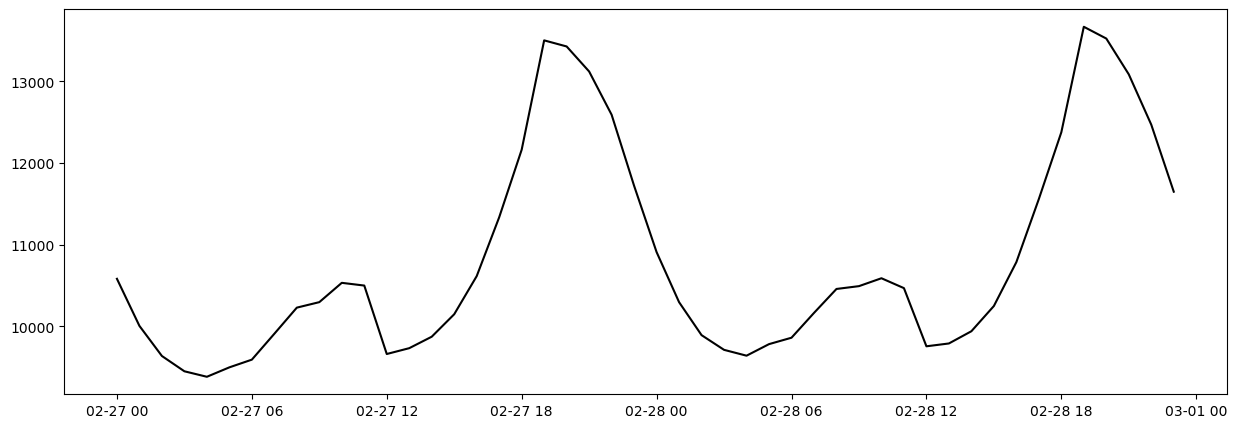